In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Unsupervised Learning Part 2 -- Clustering

Clustering is the task of gathering samples into groups of similar
samples according to some predefined similarity or distance (dissimilarity)
measure, such as the Euclidean distance.

<img width="60%" src='figures/clustering.png'/>

In this section we will explore a basic clustering task on some synthetic and real-world datasets.

Here are some common applications of clustering algorithms:

- Compression for data reduction
- Summarizing data as a reprocessing step for recommender systems
- Similarly:
   - grouping related web news (e.g. Google News) and web search results
   - grouping related stock quotes for investment portfolio management
   - building customer profiles for market analysis
- Building a code book of prototype samples for unsupervised feature extraction

Let's start by creating a simple, 2-dimensional, synthetic dataset:

In [2]:
from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X.shape

(1500, 2)

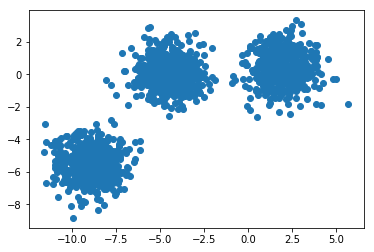

In [3]:
plt.scatter(X[:, 0], X[:, 1]);

In the scatter plot above, we can see three separate groups of data points and we would like to recover them using clustering -- think of "discovering" the class labels that we already take for granted in a classification task.

Even if the groups are obvious in the data, it is hard to find them when the data lives in a high-dimensional space, which we can't visualize in a single histogram or scatterplot.

This is the class separation we would like to recover, using only the feature data and not the labels of the dataset:

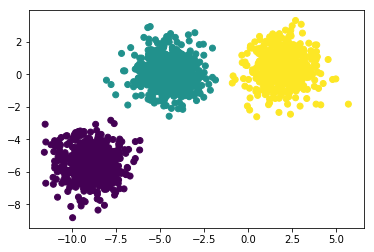

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y);

## K means

The clustering algorithm we'll look at is called "K means." This is because the algorithm works by fitting *k* center of mean points over the data. We'll choose `k=3` at first. To begin with, 3 random data points are chosen to be the first centers:

In [5]:
from sklearn.metrics import pairwise_distances_argmin

# 1. Randomly choose clusters
n_clusters = 3

rng = np.random.RandomState(random_state)
i = rng.permutation(X.shape[0])[:n_clusters]
centers = X[i]
print(i)
print(centers)

[ 820 1201  362]
[[-5.68273078 -0.46249575]
 [-4.30277286  1.5800071 ]
 [-9.19152795 -5.73763572]]


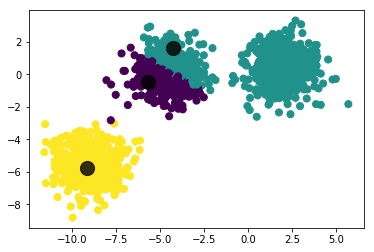

In [6]:
labels = pairwise_distances_argmin(X, centers)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8);

The labels are decided based on which center (mean) is closest to the point. Note that this plot is in two dimensions, but distance can be calculated in any number of dimensions, over all features of the dataset.

Once the current labels are calculated, re-calculate the center points as the mean position over all points with the associated label.

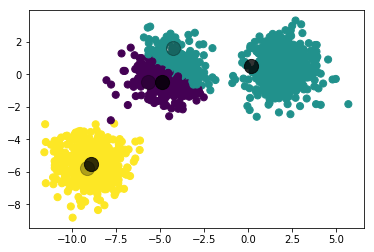

In [7]:
new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.3);
plt.scatter(new_centers[:, 0], new_centers[:, 1], c='black', s=200, alpha=0.8);

Repeat this process of labeling the data and recalculating the centers until the centers no longer move:

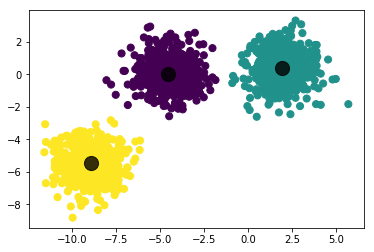

In [8]:
while True:
    # 2a. Assign labels based on closest center
    labels = pairwise_distances_argmin(X, centers)
    
    # 2b. Find new centers from means of points
    new_centers = np.array([X[labels == i].mean(0)
                            for i in range(n_clusters)])
    
    # 2c. Check for convergence
    if np.all(centers == new_centers):
        break
    centers = new_centers

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.8);

Scikit learn makes this simple for us by providing a KMeans class.

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=random_state)

We can get the cluster labels either by calling fit and then accessing the 
``labels_`` attribute of the K means estimator, or by calling ``fit_predict``.
Either way, the result contains the ID of the cluster that each point is assigned to.

In [10]:
labels = kmeans.fit_predict(X)

In [11]:
labels

array([2, 2, 1, ..., 0, 0, 0], dtype=int32)

Let's visualize the assignments that have been found

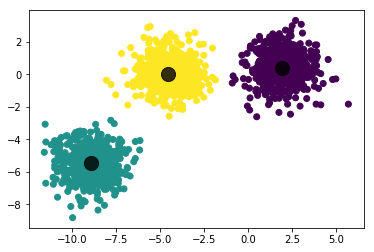

In [12]:
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=200, alpha=0.8);

Compared to the true labels:

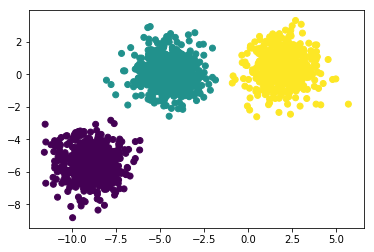

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y);

Here, we are probably satisfied with the clustering results. But in general we might want to have a more quantitative evaluation. How about comparing our cluster labels with the ground truth we got when generating the blobs?

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

print('Accuracy score:', accuracy_score(y, labels))
print(confusion_matrix(y, labels))

Accuracy score: 0.0
[[  0 500   0]
 [  0   0 500]
 [500   0   0]]


In [15]:
np.mean(y == labels)

0.0

Why is this 0.0 and not 1.0?

Even though we recovered the partitioning of the data into clusters perfectly, the cluster IDs we assigned were arbitrary,
and we can not hope to recover them. Therefore, we must use a different scoring metric, such as ``adjusted_rand_score``, which is invariant to permutations of the labels:

In [16]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(y, labels)

1.0

One of the "short-comings" of K-means is that we have to specify the number of clusters, which we often don't know *apriori*. For example, let's have a look what happens if we set the number of clusters to 2 in our synthetic 3-blob dataset:

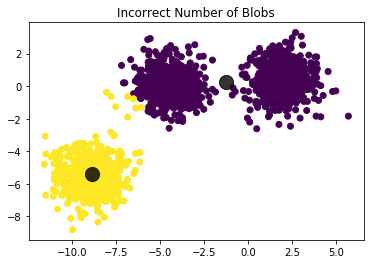

In [17]:
kmeans = KMeans(n_clusters=2, random_state=random_state)
labels = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels);
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=200, alpha=0.8)
plt.title("Incorrect Number of Blobs");

If our blobs are not distributed well, K means can also experience difficulties

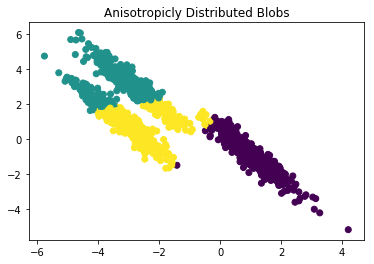

In [18]:
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred);
plt.title("Anisotropicly Distributed Blobs");

Another problem arises when we have the variances of the different classes in our data are unequal

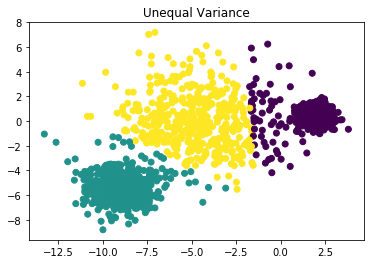

In [19]:
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred);
plt.title("Unequal Variance");

However, K means can cope with different data representation of each class, meaning the different classes have a different number of data

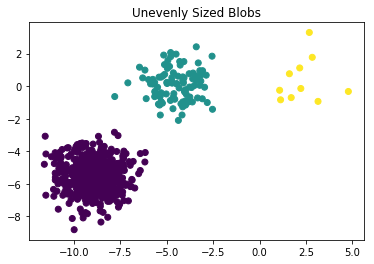

In [20]:
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred);
plt.title("Unevenly Sized Blobs");

## Other clustering algorithms

As clustering is one of the main tasks in unsupervised learning, there are many algorithms for it beyond K means. Scikit-learn provides the following:

- `sklearn.cluster.KMeans`
- `sklearn.cluster.MeanShift`
- `sklearn.cluster.DBSCAN`
- `sklearn.cluster.AffinityPropagation`
- `sklearn.cluster.SpectralClustering`
- `sklearn.cluster.Ward`

Of these, Ward, SpectralClustering, DBSCAN and Affinity propagation can also work with precomputed similarity matrices.

<img src="figures/cluster_comparison.png" width="80%">

<div class="alert alert-success">
    <b>EXERCISE: IRIS clustering</b>:
     <ul>
      <li>
      Perform K-means clustering on the iris data, searching for 3 clusters. How well does K-means match up with the actual clusters? Try clustering with other numbers.
      </li>
    </ul>
</div>

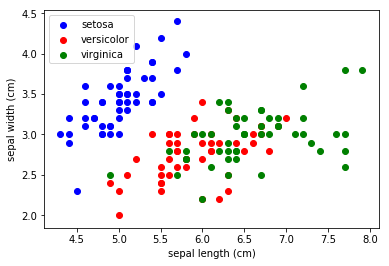

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()

x_index = 0
y_index = 1

colors = ['blue', 'red', 'green']

for label, color in zip(range(len(iris.target_names)), colors):
    plt.scatter(iris.data[iris.target==label, x_index], 
                iris.data[iris.target==label, y_index],
                label=iris.target_names[label],
                c=color)

plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.legend(loc='upper left')
plt.show()

In [22]:
# %load sols/02_iris_clustering.py

In [23]:
# adjusted_rand_score(iris.target, labels)